In [3]:
!kaggle competitions download -c nlp-getting-started

100%|████████████████████████████████████████| 593k/593k [00:00<00:00, 1.12MB/s]
100%|████████████████████████████████████████| 593k/593k [00:00<00:00, 1.12MB/s]


In [60]:
import pandas as pd
import numpy as np
import os


import matplotlib.pyplot as plt

import emoji

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

In [9]:
train = pd.read_csv("/Users/reejungkim/Documents/Git/Sentimental analysis/nlp-getting-started/train.csv")
test = pd.read_csv("/Users/reejungkim/Documents/Git/Sentimental analysis/nlp-getting-started/test.csv")

In [10]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [21]:
not_disaster = train.loc[train.target==0]
disaster = train.loc[train.target==1]

In [37]:
for i in range(0, 10):
    print(i+1 , ". ", disaster.text[i] ) 

1 .  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
2 .  Forest fire near La Ronge Sask. Canada
3 .  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
4 .  13,000 people receive #wildfires evacuation orders in California 
5 .  Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
6 .  #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
7 .  #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
8 .  I'm on top of the hill and I can see a fire in the woods...
9 .  There's an emergency evacuation happening now in the building across the street
10 .  I'm afraid that the tornado is coming to our area...


In [42]:
disaster.loc[pd.notnull(disaster.keyword)].head(3)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1


In [43]:
disaster.loc[pd.notnull(disaster.location)].head(3)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1


In [33]:
def find_url(string): 
    text = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',string)
    if text!=[]:
        return "".join(text)
    return None

In [34]:
train['url']=train['text'].apply(lambda x:find_url(x))
train.loc[pd.notnull(train.url)]

,id,keyword,location,text,target,url
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,http://t.co/lHYXEOHY6C
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,http://t.co/YAo1e0xngw
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,http://t.co/2nndBGwyEi
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,http://t.co/qqsmshaJ3N
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1,http://t.co/3ImaomknnA
...,...,...,...,...,...,...
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,http://t.co/nF4IculOje
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1,http://t.co/3SICroAaNzhttp://t.co/I27Oa0HISp
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,http://t.co/STfMbbZFB5
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,http://t.co/zDtoyd8EbJ


In [44]:
stops = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()

In [45]:
def language_preprocessor(string):
    text =  re.sub('[^a-zA-Z]', ' ', string) #replace non-english with blank
    text = text.lower().split() #decapitalize texts
    text = [word for word in text if not word in stops] #remove stopword
    text = [lm.lemmatize(word) for word in text]  #lemmatization of texts
    return text #' '.join(text)
    

In [46]:
train['text processed'] = train['text'].apply(lambda x: language_preprocessor(x)) 

In [48]:
train.head(3)

,id,keyword,location,text,target,url,text processed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,None,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,None,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,None,"[resident, asked, shelter, place, notified, of..."


In [49]:
from collections import Counter

def common_words(df, col, n):
    counts = Counter([item for sublist in df[col] for item in sublist])
    common_words = pd.DataFrame(counts.most_common(n))
    common_words.columns =['Word','count']
    return common_words
    

In [64]:
disaster_common_words  = common_words(train.loc[train.target==1], 'text processed', 100)
disaster_common_words.head(5)

,Word,count
0,co,2534
1,http,2517
2,fire,268
3,u,155
4,news,151


In [65]:

words = disaster_common_words.set_index("Word")['count'].to_dict()


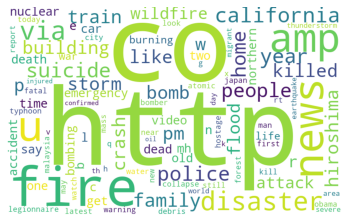

In [66]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white', width=800, height=500)
wordcloud = wc.generate_from_frequencies(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()